# The intense drought on the Po river basin in summer 2022

<p align="center">
 <a href="https://www.greenandblue.it/2022/07/04/news/siccita_po_e_altri_fiumi_da_satellite-356491116/">
<img src="https://github.com/iacopoff/climetlab-cems-flood/blob/main/docs/source/tutorial/img.png">
 </a>
</p>

The 2022 drought was one of the worst ever recorder on the Po basin.

The event was so severe that it was also reported in international newspapers, such as The Guardian: [Quiet flows the Po: the life and slow death of Italy's longest river](https://www.theguardian.com/environment/2022/jul/10/po-river-italy-drought-climate)

The summer season started with water levels already in deficit due to below average winter and spring precipitation. </br>
I decided that I would check the GloFAS seasonal forecast on the Po river, to see whether some relief was on sight. 

In this notebook I am going to show how easy it is to get data from the CDS to create some nice story.

In [1]:
import climetlab as cml
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num
import datetime
import pandas as pd
import numpy as np

In [2]:
# pontelagoscuro
ps = {'name':'pontelagoscuro','lat':44.886111, 'lon':11.604444}

In [251]:
seasonal = cml.load_dataset(
            'cems-glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-12 *',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps], 
            split_on=["month"],
            threads= 9
)

In [252]:
water_balance = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            temporal_filter= '2022 01-12 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            # split_on = ['hmonth'],
            # threads = 6
        )

In [296]:
climatology_2000_2021 = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2000-2021 01-12 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hyear'],
            threads = 21
        )

Let's check where the station is located, and if it is in the correct GloFAS grid cells, so that we know we are getting the river discharge timeseries we wanted.

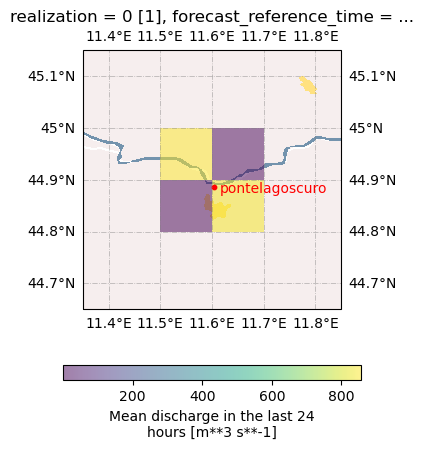

In [5]:
seasonal.show_coords('pontelagoscuro')

In [297]:
cl = climatology_2000_2021.to_xarray()

In [302]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True)

cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True)

cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [303]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmean = cmean.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmax= cmax.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmin = cmin.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

In [253]:
seas = seasonal.to_xarray()

In [255]:
wb = water_balance.to_xarray()

In [256]:
wbl = wb.sel(latitude=ps['lat'],longitude=ps['lon'], method="nearest")

In [276]:
dfwb = wbl.to_dataframe().reset_index()
dfwb.drop(["latitude", "longitude"], axis=1, inplace=True)
dfwb = dfwb[(dfwb.time.dt.month >= 1) & (dfwb.time.dt.month <= 12) ]

In [277]:
dfwb['time'] =  pd.DatetimeIndex(dfwb.time)

In [259]:
df = seas.sel(lat=ps['lat'],lon=ps['lon'], method="nearest").to_dataframe() # leadtime=range(0,150,15)

In [260]:
df.drop(['lat','lon'], axis=1, inplace=True)

In [278]:
df2= df.reset_index()

In [392]:
df3 = df2[df2.time.dt.day.isin([2,9,16,23])]

In [393]:
leadtimes = df3.leadtime.dt.days.unique()

In [394]:
leadtimes

array([  1,   8,  15,  22,  32,  39,  46,  53,  60,  67,  74,  81,  91,
        98, 105, 112, 121, 128, 135, 142,  29,  36,  43,  50,  90,  97,
       104, 111,  62,  69,  76,  83,  93, 100, 107, 114, 123, 130, 137,
       144,  31,  38,  45,  52,  92,  99, 106, 113, 124, 131, 138, 145,
        63,  70,  77,  84, 122, 129, 136, 143])

In [395]:
df3 = df3.drop(["leadtime"], axis= 1)

In [396]:
df3 = df3.loc[(df3.time.dt.month >= 1) & ( df3.time.dt.month <= 12)]

In [397]:
df3.reset_index(drop=True, inplace=True)

In [398]:
df3['time'] = pd.DatetimeIndex(df3.time)

In [399]:
df3['time'] = df3.time.dt.strftime("%Y-%m-%d")

In [400]:
import matplotlib.dates as mdates

In [401]:
def get_data(df3, finit):
    Fi1 = df3[df3.forecast_reference_time == finit] 
    Fi1_g = Fi1.groupby("time")
    Fi1_g.groups.keys()
    Fi1vals = []
    for t in Fi1.time.unique():
        vnew = Fi1.loc[Fi1_g.groups[t]]["dis24"].values
        Fi1vals.append(vnew)
    Fi1vals = np.stack(Fi1vals).T
    xpositions = [date2num(datetime.datetime.strptime(t, "%Y-%m-%d")) for t in Fi1.time.unique()]
    return Fi1vals, xpositions 

Text(0.02, 0.5, 'Discharge m3/s')

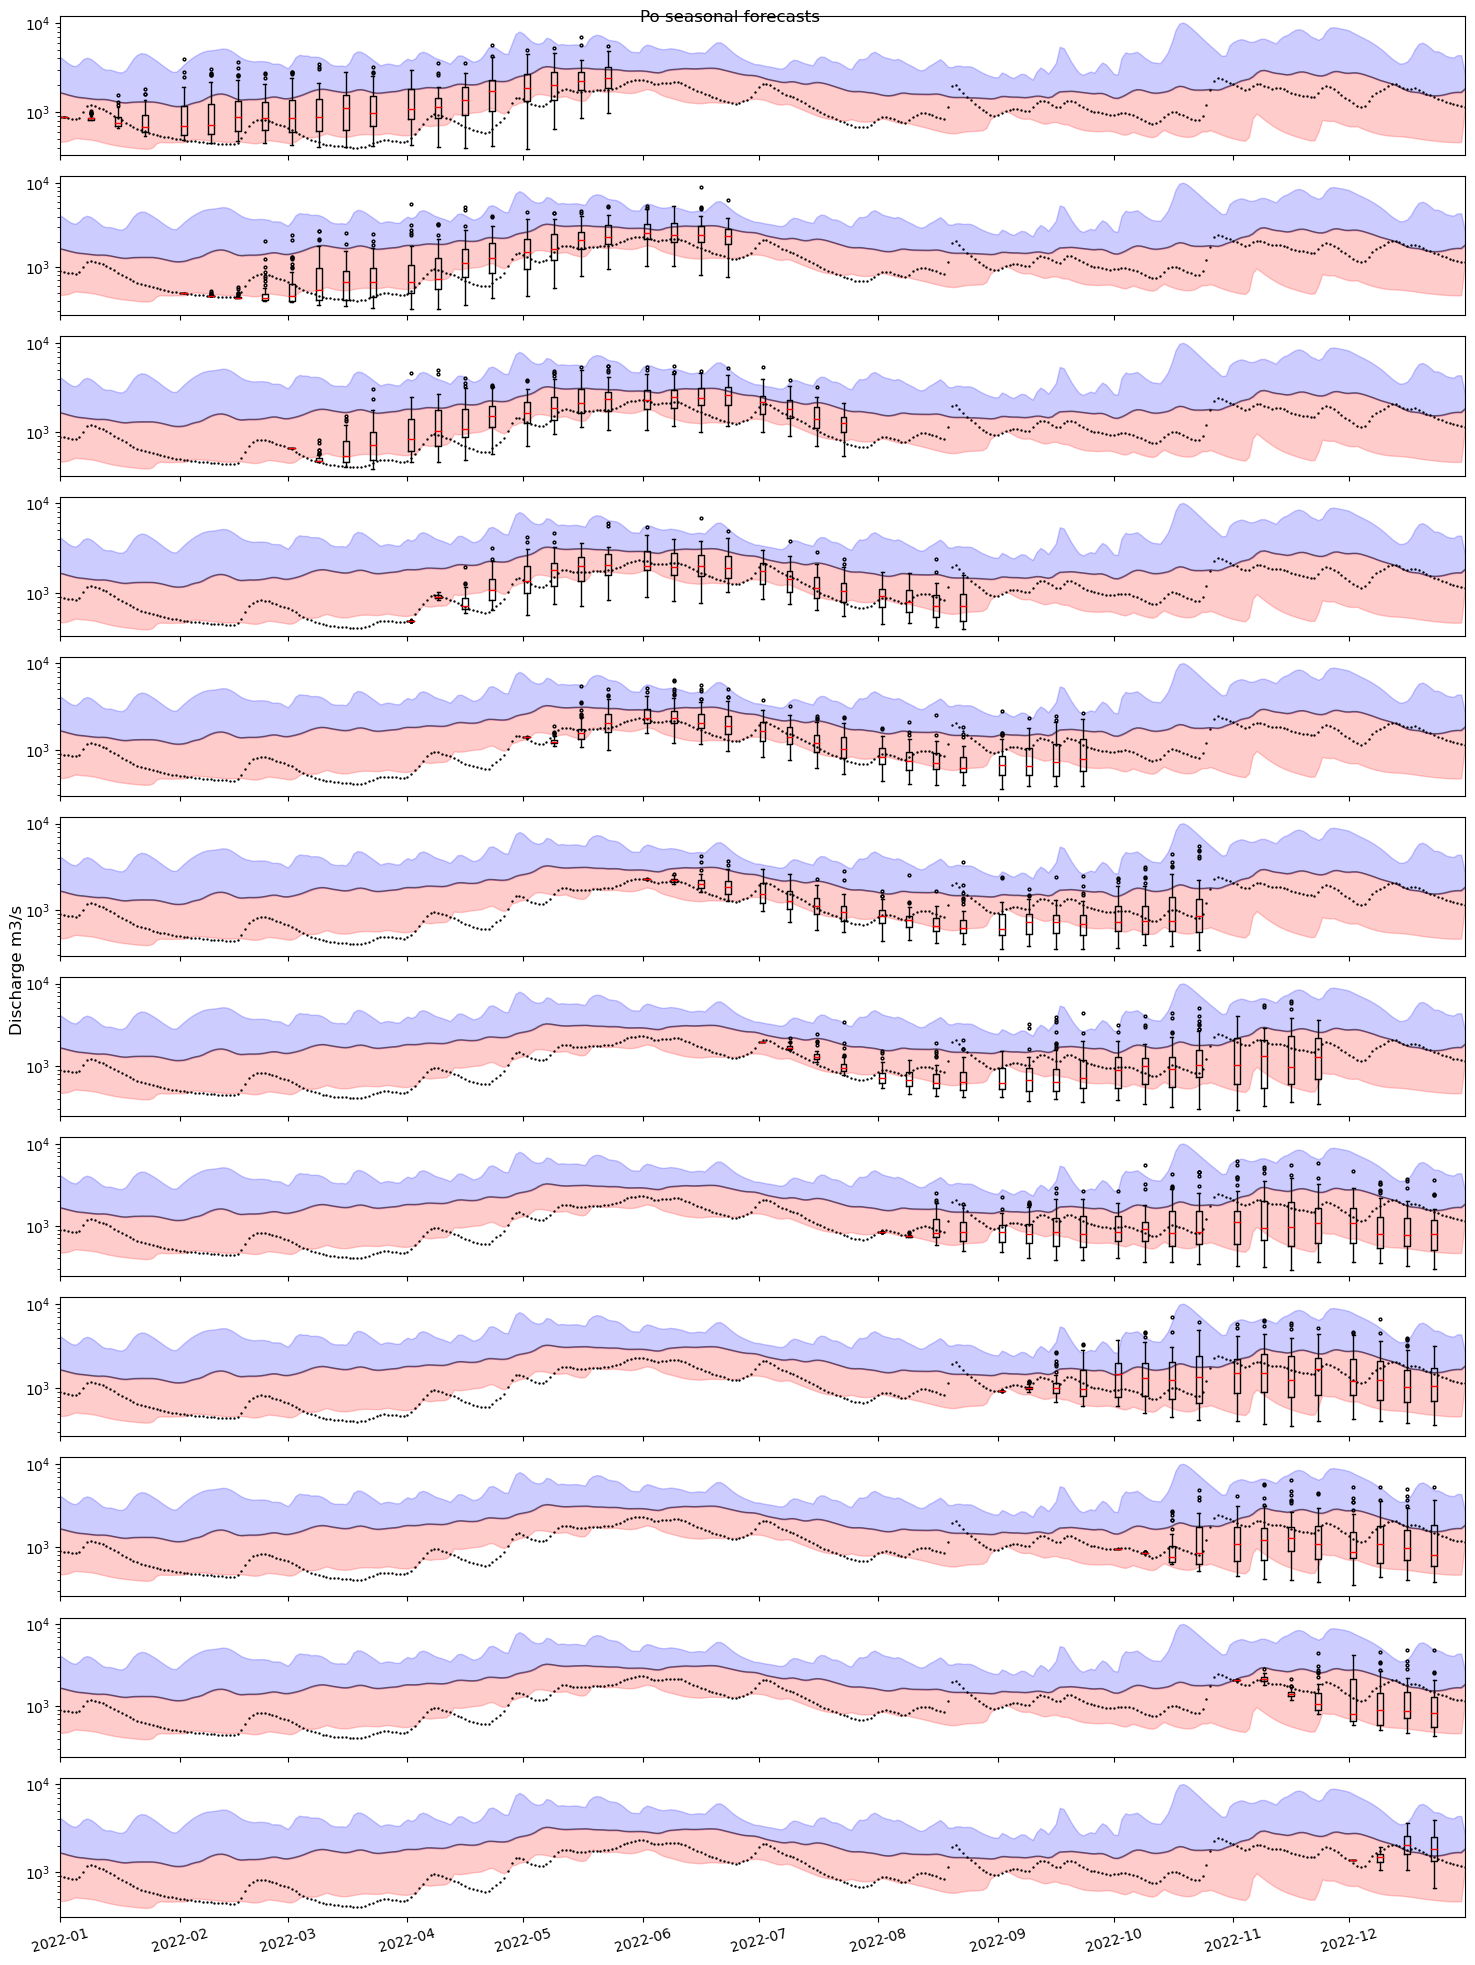

In [402]:
finits = df3.forecast_reference_time.dt.strftime("%Y-%m-%d").unique()
fig, axs = plt.subplots(len(finits),1,figsize=(15,20), sharex=True, tight_layout=True)

wt = [date2num(i) for i in dfwb.time]
x_date = pd.date_range("2022-01-01","2022-12-31",freq="MS")
x_date = pd.to_datetime(x_date,"%Y-%m-%d")


flierprops = dict(marker='o', markersize=2, linestyle='none')
medianprops = dict(color="red",linewidth=1)
boxprops = dict(color="black",linewidth=1)
                   
timevals = pd.date_range("2022-01-01","2022-12-31",freq="D")
cmeanvals = cmean.dis24.values.T
cmaxvals = cmax.dis24.values.T
cminvals = cmin.dis24.values.T

for i, f in enumerate(finits):
    fivals, xpositions = get_data(df3, f)
    axs[i].fill_between(timevals,cmeanvals,cmaxvals,color="blue",alpha=0.2)
    axs[i].fill_between(timevals,cminvals,cmeanvals,color="red",alpha=0.2)
    axs[i].plot(timevals,cmeanvals, linewidth=1, color="black",label = "climatology 2000-2021", alpha=0.5)
    axs[i].boxplot(fivals, positions=xpositions, widths=1.5, boxprops=boxprops,flierprops=flierprops,medianprops=medianprops, labels=leadtimes[:fivals.shape[1]]);
    axs[i].scatter(wt, dfwb.dis24, s=0.5, c="black")
    axs[i].set_xlim([wt[0], wt[-1]])
    axs[i].set_yscale("log")

    axs[i].set_xticks(x_date)
    axs[i].set_xticklabels(x_date.values, rotation=15)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# x_date2 = pd.date_range("2022-05-01","2022-09-30",freq="1D")
# x_date2 = pd.to_datetime(x_date2,"%Y-%m-%d")
# ax.set_xticks(x_date2,minor=True)
# ax.set_xticklabels(x_date2.values, rotation=45, minor=True,fontsize=6)
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

fig.suptitle("Po seasonal forecasts")
fig.supylabel("Discharge m3/s")
